# Frozen Lake Testing

Short notebook just playing around with the Frozen Lake environment to get a feel for it.

In [36]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from crl.envs.frozen_lake import make_env
from crl.utils.graphing import get_robust_perf_stats, plot_robust_perf_curve, despine
from tqdm import trange

from dataclasses import dataclass
from collections import deque

## Define a tabular agent to solve the env for a fixed map

Using a value-function based Dyna setup

S <- current state\
A <- epsilon-greedy V(s') for all possible actions\
receive S', R\
Model(S, A, S') <- (running average)\
Loop:\
&nbsp;&nbsp;&nbsp;&nbsp;S <- random previously observed state\
&nbsp;&nbsp;&nbsp;&nbsp;A <- random previously taken action\
&nbsp;&nbsp;&nbsp;&nbsp;R, S' <- sample from Model(S, A)\
&nbsp;&nbsp;&nbsp;&nbsp;V(s) = V(s) + alpha [R + gamma V(s') - V(s)]

In [124]:
from typing import Protocol, Any, runtime_checkable

type State = int
type Action = int
type Reward = float
type Observation = tuple[State, Action, Reward, State]


@runtime_checkable
class Predictor(Protocol):
    def conformalise(
        self, preds: np.ndarray, state: "State", action: "Action"
    ) -> list["State"]: ...

    def observe(self, obs: 'Observation', wm_prob: float) -> None: ...


class NoPredictor:
    "A no-op predictor - doesn't do any conformal prediction"
    def __init__(self) -> None:
        pass

    def conformalise(
        self, preds: np.ndarray, state: "State", action: "Action"
    ) -> list["State"]:
        return [int(preds.argmax())]

    def observe(self, obs: 'Observation', wm_prob: float) -> None:
        pass


class PredictorSAConditioned:
    def __init__(
        self,
        S: int,
        A: int,
        alpha: float,
        n_calib: int = 100,
        min_count: int | None = None,
    ):
        self.alpha = alpha
        self.q_level = np.ceil((n_calib + 1) * (1 - alpha)) / n_calib

        # if min_count is not specified, require a calibration set to be full to use it
        self.min_count = min_count or n_calib

        # sets up the calibration sets with a deque per state-action pair. Note this is very gnarly memory-wise for non trivial MDPs
        self.calib_set = np.empty((S, A), dtype=object)
        for i, j in np.ndindex(S, A):
            self.calib_set[i, j] = deque(maxlen=n_calib)
        self.qhat = np.zeros((S, A)) + 1.0

    def conformalise(
        self, preds: np.ndarray, state: "State", action: "Action"
    ) -> list["State"]:
        calib_set = self.calib_set[state, action]

        # if the calibration set isn't full, just return the argmax of the scores
        if len(calib_set) < self.min_count:
            return [int(preds.argmax())]

        prediction_sets = preds >= (1 - self.qhat[state, action])
        prediction_sets = np.flatnonzero(prediction_sets).tolist()
        if not prediction_sets:
            return [preds.argmax()]  # type: ignore

        return prediction_sets

    def observe(self, obs: 'Observation', wm_prob: float) -> None:
        s, a, r, s_prime = obs
        self.calib_set[s, a].append(1 - wm_prob)
        self.qhat[s, a] = np.quantile(
            self.calib_set[s, a], self.q_level, method="higher"
        )


class PredictorGlobal:
    def __init__(
        self, alpha: float, n_calib: int = 100, min_count: int | None = None
    ) -> None:
        self.alpha = alpha
        self.q_level = np.ceil((n_calib + 1) * (1 - alpha)) / n_calib

        # if min_count is not specified, require a calibration set to be full to use it
        self.min_count = min_count or n_calib

        self.calib_set = deque(maxlen=n_calib)
        self.qhat = 1.0

    def conformalise(
        self, preds: np.ndarray, state: "State", action: "Action"
    ) -> list["State"]:
        if len(self.calib_set) < self.min_count:
            return [int(preds.argmax())]

        prediction_sets = preds >= (1 - self.qhat)
        prediction_sets = np.flatnonzero(prediction_sets).tolist()
        if not prediction_sets:
            return [preds.argmax()]  # type: ignore

        return prediction_sets

    def observe(self, obs: 'Observation', wm_prob: float) -> None:
        self.calib_set.append(1 - wm_prob)
        self.qhat = np.quantile(self.calib_set, self.q_level, method="higher")


assert issubclass(NoPredictor, Predictor)
assert issubclass(PredictorGlobal, Predictor)
assert issubclass(PredictorSAConditioned, Predictor)

In [136]:
@dataclass
class AgentParams:
    # Agent Learning Params
    epsilon: float
    learning_rate: float
    # Conformal Prediction
    use_cp: bool = False
    # Extra utility
    n_plan_steps: int = 5
    discount: float = 1.0
    rng: int | None = None


# TODO: implement conformalisation
# TODO: the annotations are stringified for use with joblib in a notebook - change when shifting to script
class DynaVAgent:
    def __init__(
        self,
        env: gym.Env,
        params: AgentParams,
        predictor: Predictor,
    ) -> None:
        S = env.observation_space.n
        A = env.action_space.n

        # setup world model, reward model and value function
        self._setup_models(S, A)

        # rng
        if params.rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = np.random.default_rng(params.rng)

        # learning parameters
        self.epsilon = params.epsilon
        self.discount = params.discount
        self.learning_rate = params.learning_rate
        self.n_plan_steps = params.n_plan_steps

        # conformal parameters
        self.predictor = predictor

    def _setup_models(self, S: int, A: int) -> None:
        # define arrays for a simple counting world model
        # N: |S|x|A|x|S|
        # M: |S|x|A|x|S|
        # R: |S|x|A|
        self.actions = range(A)
        self.states = range(S)
        self.N = np.zeros((S, A, S))
        self.world_model = np.zeros((S, A, S)) + (1 / S)  # init to equal probs
        self.reward_model = np.zeros((S, A))

        # define the value function
        # V: |S|
        self.V = np.zeros(S)

    def select_action(self, s: "State") -> "Action":
        if self.rng.random() < self.epsilon:
            return self._random_action()
        return self._greedy_action(s)

    def _random_action(self) -> "Action":
        return self.rng.choice(self.actions)

    def _greedy_action(self, s: "State") -> "Action":
        a_next = -1
        v_next = -np.inf

        for a in self.actions:
            # s_pred = self.world_model[s, a].argmax()
            wm_predictions = self.world_model[s, a]
            next_states = self.predictor.conformalise(wm_predictions, s, a)
            G_worstcase = self.reward_model[s, a] + min(self.V[s_pred] for s_pred in next_states)
            if G_worstcase > v_next:
                v_next = G_worstcase
                a_next = a

        return a_next

    def observe(self, obs: "Observation") -> None:
        """Takes in an observation (S, A, R, S') and updates the value function,
        world model and conformal predictor"""
        s, a, r, s_prime = obs
        # value function - TD(0) update
        self.V[s] += self.learning_rate * (
            r + self.discount * self.V[s_prime] - self.V[s]
        )

        # model learning - counting since tabular
        self.N[s, a, s_prime] += 1
        self.world_model[s, a, :] = self.N[s, a, :] / self.N[s, a, :].sum()
        self.reward_model[s, a] = r

        self.predictor.observe(obs, self.world_model[s, a, s_prime])

    def plan(self) -> None:
        "Conduct imagined updates using the world model to refine the value function"
        # No planning until the model has correctly completed an episode
        if self.reward_model.max() < 1:
            return
        for _ in range(self.n_plan_steps):
            # Sample a previously observed transition
            coords = np.argwhere(self.N)
            s, a, s_prime = coords[self.rng.choice(len(coords))]

            # value function update - TD(0)
            model_r = self.reward_model[s, a]
            self.V[s] += self.learning_rate * (model_r + self.discount * self.V[s_prime] - self.V[s])
    
    def reset(self) -> None: ...

In [154]:
def train_agent(
    slip_prob: float = 0.15,
    n_episodes: int = 10_000,
    epsilon_init: float = 1.0,
    rng: int = 42,
) -> tuple[DynaVAgent, list['Reward']]:
    # setup env
    env = make_env(seed=rng, slip_prob=slip_prob)()
    state, info = env.reset()

    # setup agent
    params = AgentParams(
        learning_rate=0.1, epsilon=epsilon_init, discount=0.99, rng=rng
    )
    predictor = PredictorSAConditioned(S=16, A=4, alpha=0.9, n_calib=100)
    agent = DynaVAgent(env, params, predictor)

    # train the agent
    returns = []
    for episode in range(n_episodes):
        if episode > 0:
            agent.epsilon = max(0, epsilon_init * (1 - (episode - 0) / (n_episodes // 2)))
        done = False
        state, info = env.reset()
        while not done:
            # execute an action to interact with the MDP
            action = agent.select_action(state)
            state_next, reward, terminated, truncated, info = env.step(action)
            obs = (state, action, reward, state_next)
            agent.observe(obs)
            state = state_next

            # Perform planning to refine the value function
            agent.plan()

            done = terminated or truncated
            if done:
                returns.append(reward)

    return agent, returns


In [155]:
from joblib import Parallel, delayed
from tqdm import tqdm

# Define the function to be parallelized
def run_single_experiment(slip_prob, seed) -> tuple[DynaVAgent, list[float]]:
    # This function should contain the logic for one run
    # Note: It's often better to instantiate the agent and env inside
    # the worker process to avoid pickling issues.
    agent, exp_returns = train_agent(slip_prob=slip_prob, rng=seed)
    return agent, exp_returns


# Main loop
n_runs = 50
SLIP_PROBS = [0.0, 0.15, 0.3]
all_returns = {sp: [] for sp in SLIP_PROBS}
for slip_prob in tqdm(all_returns):
    # print(f"Running experiments for slip_prob={slip_prob}...")
    tasks = (delayed(run_single_experiment)(slip_prob, run) for run in range(n_runs))

    # Wrap the Parallel object, which is a generator of results
    results = Parallel(n_jobs=-1)(tasks)
    all_returns[slip_prob] = [res[1] for res in results]

100%|██████████| 3/3 [01:57<00:00, 39.02s/it]


100%|██████████| 2000/2000 [00:06<00:00, 295.03it/s]


Slip prob: 0.00, Last 100 eps IQM: 1.000
Slip prob: 0.15, Last 100 eps IQM: 0.986
Slip prob: 0.30, Last 100 eps IQM: 0.613


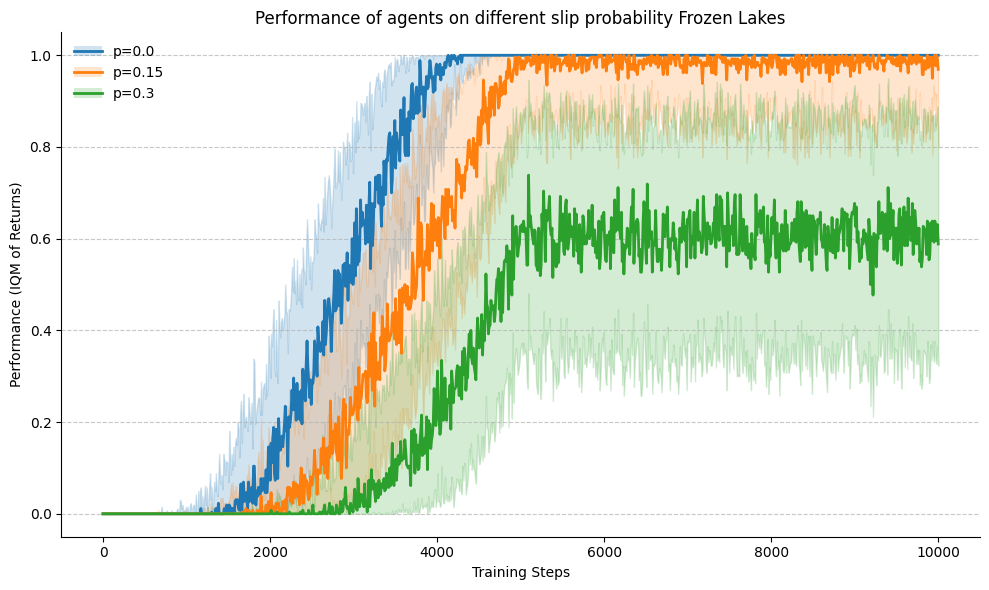

In [156]:
from matplotlib.legend_handler import HandlerTuple

fig, ax = plt.subplots(figsize=(10, 6))
legend_handles = []
legend_labels = []
metrics = {}

for ix, slip_prob in enumerate(SLIP_PROBS):
    exp_returns = np.array(all_returns[slip_prob])
    stats = get_robust_perf_stats(exp_returns, n_bootstrap_samples=2000, pbar=True)
    handle, label = plot_robust_perf_curve(
        ax, stats, label=f"p={slip_prob}", color=f"C{ix}", smooth=10
    )
    legend_handles.append(handle)
    legend_labels.append(label)

    metrics[slip_prob] = stats['iqm'][-100:].mean()

despine(ax)
ax.set_title("Performance of agents on different slip probability Frozen Lakes")
ax.set_xlabel("Training Steps")
ax.set_ylabel("Performance (IQM of Returns)")
ax.legend(
    legend_handles,
    legend_labels,
    handler_map={tuple: HandlerTuple(ndivide=1, pad=0)},
    frameon=False,
    loc="best",
)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

for slip_prob, asym_return in metrics.items():
    print(f'Slip prob: {slip_prob:.2f}, Last 100 eps IQM: {asym_return:0.3f}')
plt.show()

In [157]:
agent = results[0][0]
agent.predictor.calib_set[0, 0]
np.vectorize(lambda x: len(x))(agent.predictor.calib_set)

array([[100, 100, 100, 100],
       [100, 100, 100, 100],
       [100, 100, 100, 100],
       [100, 100, 100, 100],
       [100, 100, 100, 100],
       [  0,   0,   0,   0],
       [100, 100, 100, 100],
       [  0,   0,   0,   0],
       [100, 100, 100, 100],
       [100, 100, 100, 100],
       [100, 100, 100, 100],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [100, 100, 100, 100],
       [100, 100, 100, 100],
       [  0,   0,   0,   0]])

In [161]:
ACTION_MAP = {
    'left': 0, 'down': 1, 'right': 2, 'up': 3
}

# preds: np.ndarray, state: "State", action: "Action"
state = 0
action = ACTION_MAP['right']
preds = agent.world_model[state, action]
agent.predictor.conformalise(preds, state, action)
# agent.predictor.conformalise(np.array([]), state=0, action=ACTION_MAP['right'])

[1]

In [133]:
# 1000 eps, plan 15
# Slip prob: 0.00, Last 100 eps IQM: 1.000
# Slip prob: 0.15, Last 100 eps IQM: 0.763
# Slip prob: 0.30, Last 100 eps IQM: 0.462

# 2000 eps, plan 15
# Slip prob: 0.00, Last 100 eps IQM: 1.000
# Slip prob: 0.15, Last 100 eps IQM: 0.989
# Slip prob: 0.30, Last 100 eps IQM: 0.633

# 2000 eps, plan 1
# Slip prob: 0.00, Last 100 eps IQM: 1.000
# Slip prob: 0.15, Last 100 eps IQM: 0.987
# Slip prob: 0.30, Last 100 eps IQM: 0.669

# 2000 eps, plan 0
# Slip prob: 0.00, Last 100 eps IQM: 1.000
# Slip prob: 0.15, Last 100 eps IQM: 0.922
# Slip prob: 0.30, Last 100 eps IQM: 0.646

In [ ]:
# def plot_value_function(V: np.ndarray):
#     vals_reshaped = V.reshape((4, 4))

#     fig, ax = plt.subplots()
#     im = ax.imshow(vals_reshaped, cmap="viridis")

#     # Put the value annotations back in
#     for i in range(vals_reshaped.shape[0]):
#         for j in range(vals_reshaped.shape[1]):
#             ax.text(j, i,
#                     f"{vals_reshaped[i, j]:.2f}",
#                     ha="center", va="center",
#                     color="white" if vals_reshaped[i, j] < vals_reshaped.mean() else "black")

#     # --- NEW: integer ticks 0-3 on both axes ---
#     ax.set_xticks(np.arange(4))
#     ax.set_yticks(np.arange(4))
#     ax.set_xticklabels(np.arange(4))
#     ax.set_yticklabels(np.arange(4))

#     plt.tight_layout()
#     plt.show()

# plot_value_function(agent.V)

NameError: name 'agent' is not defined

In [6]:
returns = np.array(returns)
plt.plot(returns.reshape(-1, 100).mean(1))

NameError: name 'returns' is not defined

In [ ]:
# eval
agent.epsilon = 0.0

eval_returns = []
for episode in trange(1_000):
    done = False
    state, info = env.reset()
    while not done:
        action = agent.select_action(state)
        state_next, reward, terminated, truncated, info = env.step(action)
        state = state_next

        done = terminated or truncated
        if done:
            eval_returns.append(reward)

100%|██████████| 1000/1000 [00:00<00:00, 9108.37it/s]


In [ ]:
# plt.plot(eval_returns)
np.mean(eval_returns)

np.float64(0.718)

In [ ]:
agent.reward_model[-2]

array([0., 1., 0., 0.])